# Celebface GAN

## Importing Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
import cv2

from IPython import display

## Organising Dataset

In [ ]:
dir_data = "celeba/images/"
Ntrain = 150000
nm_imgs = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]

img_shape = (64, 64, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = tf.keras.preprocessing.image.load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = (tf.keras.preprocessing.image.img_to_array(image) - 127.5) / 127.5
        X_train.append(image)
        display.clear_output(wait=True)
        print(i+1)
        
    X_train = np.array(X_train)
    np.save('celeb_a_numpy/celeb_a_numpy', X_train)
    X_train = []
        
get_npdata(nm_imgs_train)

In [2]:
train_dataset = np.load('celeb_a_numpy/celeb_a_numpy.npy')

In [3]:
train_dataset.shape

(150000, 64, 64, 3)

In [4]:
BUFFER_SIZE = 150000
BATCH_SIZE = 32

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [2]:
class Generator(object):
    def __init__(self):
        self.model = self.__make_generator_model()
        
    def __make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((4, 4, 1024)))
        assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

        #layers.Conv2DTranspose(no_of_filters, (kernel_size_x, kernel_size_y), strides=(stride_x, stride_y), padding='same and valid are not the same', use_bias=False)
        model.add(layers.Conv2DTranspose(1024, (4, 4), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, 4, 4, 1024)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 8, 8, 512)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 16, 16, 256)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 32, 32, 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 64, 64, 3)
        '''
        model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 128, 128, 3)
        '''

        return model
    
    def predict(self, x, training=True):
        return self.model(x, training)

In [3]:
generator = Generator()
generator.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 1024)        16777216  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 1024)        0

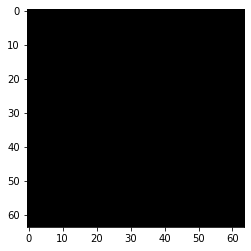

In [4]:
noise = tf.random.normal([1, 100])      # noise
generated_image = generator.predict(noise, training=False)

plt.imshow(np.uint8(generated_image[0, :, :, :]))    # generated image from noise

## Discriminator

In [5]:
class Discriminator(object):
    def __init__(self):
        self.model = self.__make_discriminator_model()
    
    def __make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same',
                                         input_shape=[64, 64, 3]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(1024, (4, 4), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        '''
        model.add(layers.Conv2D(1024, (4, 4), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        '''
        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model
    
    def predict(self, x, training=True):
        return self.model(x, training)

In [6]:
discriminator = Discriminator()
discriminator.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       6272      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       524544    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)        

In [7]:
decision = discriminator.predict(generated_image, training=False)       # verdict of discriminator
print(decision)

tf.Tensor([[0.00010199]], shape=(1, 1), dtype=float32)


## Losses

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    #return tf.reduce_mean(real_output - fake_output)    wgan

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    #return tf.reduce_mean(fake_output)    wgan

## Optimizers

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator.model,
                                 discriminator=discriminator.model)

## Training

In [13]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator.predict(noise, training=True)

        real_output = discriminator.predict(images, training=True)
        fake_output = discriminator.predict(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.model.trainable_variables))

In [15]:
def train(dataset, epochs):
    for epoch in range(15, epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator.model,
                                epoch + 1,
                                seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator.model,
                            epochs,
                            seed)

In [16]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig=plt.figure(figsize=(16, 16))   
    columns = 4
    rows = 1

    for i in range(predictions.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(np.uint8(predictions[i, :, :, :] * 127.5 + 127.5))

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

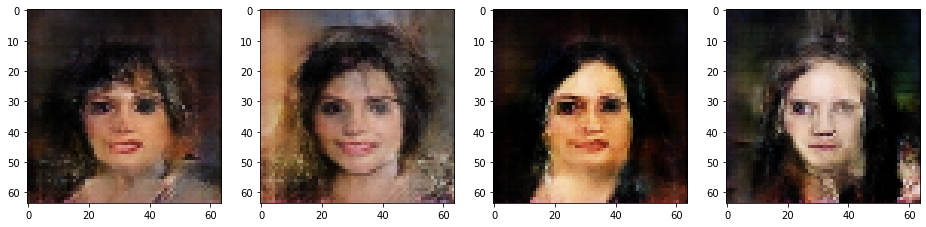

Time for epoch 30 is 1661.426370382309 sec


In [22]:
train(train_dataset, EPOCHS)

In [18]:
generator.model.save('models/celeba-generator-64x64.h5')

## Test and GIF

In [2]:
generator_test = tf.keras.models.load_model('models/celeba-generator-64x64.h5')

In [20]:
anim_file = 'celeba.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

## Test with random noise

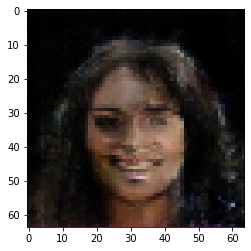

In [3]:
noise = tf.random.normal([1, 100])
generated_test_image = generator_test.predict(noise)[0]#.numpy()
plt.imshow(np.uint8((generated_test_image * 127.5) + 127.5))

## Saving collage

In [3]:
images_per = []
images = []
for i in range(25):
    latent_space = tf.random.normal([1, 100])
    generated_test_image = generator_test.predict(latent_space)[0]#.numpy()
    generated_test_image = np.uint8((generated_test_image * 127.5) + 127.5)
    images_per.append(generated_test_image)
    if len(images_per) == 5:
        images.append(images_per)
        images_per = []

In [4]:
collage = np.hstack((i for i in images[0]))
for i in range(1, len(images)):
    horizontal = images[i][0]
    for j in range(1, len(images[i])):
        horizontal = np.hstack((horizontal, images[i][j]))
    collage = np.vstack((collage, horizontal))

imgs_comb = PIL.Image.fromarray(collage)
imgs_comb.save('celeba_collage.jpg' )